In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader

In [3]:
# this is to make sure that the mibi top level package is in the python path
import sys
sys.path.append("..")
from mibi.preprocess.mibi_image import *
from mibi.preprocess.mibi_plot import *
#from mibi.nets.utils import PatchMaker
from mibi.nets.bgsub.dataset import BackgroundSubtractionDataset

In [4]:
data_dir = '/Users/mschachter/data/CHOP_TMA_pilot'
images_dir = os.path.join(data_dir, 'extracted_subset')
channels_data_path = os.path.join(data_dir, 'info', 'channels.csv')

ds = BackgroundSubtractionDataset(images_dir, channels_data_path)

#mp_images = dict()
#for pdir in glob.glob(os.path.join(images_dir, 'Point*')):
#    _,pname = os.path.split(pdir)
#    print(f"Loading from {pdir}")
#    mp_images[pname] = MIBIMultiplexImage.load_from_path(os.path.join(pdir, 'TIFs'), channels_data_path)


Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point4
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point19
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point8
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point22


In [5]:
ds.df#.sample(n=50)

,point_name,channel_label,channel_local_index,patch_index
0,Point4,nuclear,0,0
1,Point4,nuclear,0,1
2,Point4,nuclear,0,2
3,Point4,nuclear,0,3
4,Point4,nuclear,0,4
...,...,...,...,...
499,Point22,GFAP,13,4
500,Point22,GFAP,13,5
501,Point22,GFAP,13,6
502,Point22,GFAP,13,7


X.shape= torch.Size([1, 512, 512])
Y.shape= torch.Size([1, 512, 512])


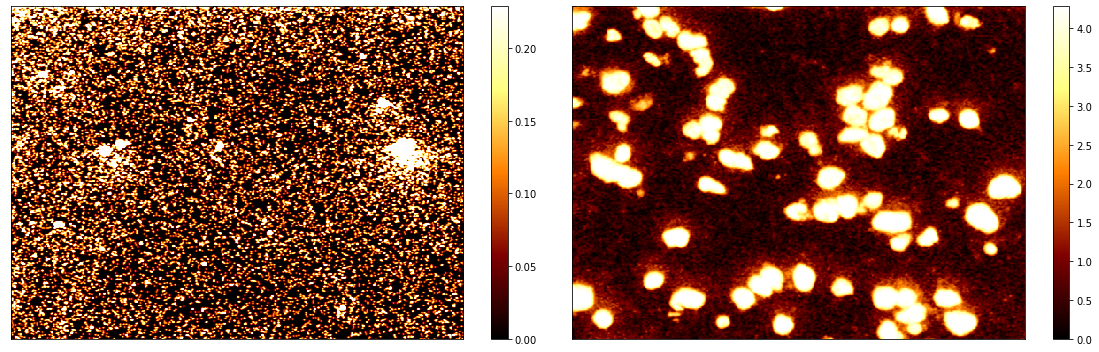

In [6]:
X,Y = ds[0]
print('X.shape=',X.shape)
print('Y.shape=',Y.shape)

fig = plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 2, 1)
plot_img(X.numpy().squeeze())
ax = plt.subplot(1, 2, 2)
plot_img(Y.numpy().squeeze())
plt.tight_layout()

In [7]:
def tensor_mem(t):
    nelems = np.prod(t.shape)
    mem_gb = (nelems*4) / 1000.**3
    print(f"Mem: {mem_gb:.2f}GB, Shape: ({','.join([str(s) for s in t.shape])})")

tensor_mem(ds.gold_patches['Point4'])

Mem: 0.01GB, Shape: (9,512,512)


In [8]:
tensor_mem(ds.chan_patches['Point4'])

Mem: 0.13GB, Shape: (14,9,512,512)


In [9]:
from torch.utils.data import DataLoader
batch_size = 7
loader_args = dict(batch_size=batch_size)
loader = DataLoader(ds, shuffle=True, **loader_args)

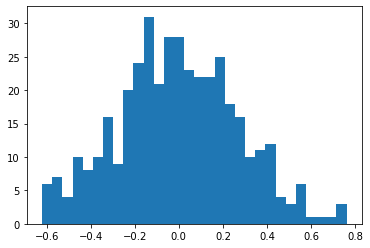

In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn_init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn_init.constant_(m.bias, 0)

conv_layer = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
init_weights(conv_layer)
plt.hist(conv_layer.weight.detach().numpy().ravel(), bins=30);

In [17]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

In [25]:
X,Y = ds[6]
#ms_ssim_val = ms_ssim( X.unsqueeze(0), Y.unsqueeze(0), data_range=84, size_average=False )
ms_ssim_val = ms_ssim( X.unsqueeze(0), X.unsqueeze(0), data_range=84, size_average=False )
ms_ssim_val

tensor([1.])

In [13]:
simple_conv_net = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1, padding=0),
    nn.ReLU(inplace=True)
)
simple_conv_net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (3): ReLU(inplace=True)
)

In [49]:
class BGSubAndDenoisier(nn.Module):
    def __init__(self, num_preproc_channels=32):
        super(BGSubAndDenoisier, self).__init__()
        
        self.bg_preproc = nn.Conv2d(in_channels=1, out_channels=num_preproc_channels,
                                    kernel_size=3, padding=1)
        self.bg_preproc_act = nn.ReLU(inplace=True)
        
        self.chan_preproc = nn.Conv2d(in_channels=1, out_channels=num_preproc_channels,
                                      kernel_size=3, padding=1)
        self.chan_preproc_act = nn.ReLU(inplace=True)
        
        num_mix_channels = num_preproc_channels*2
        self.mix = nn.Conv2d(in_channels=2*num_preproc_channels, out_channels=num_mix_channels,
                             kernel_size=3, padding=1)
        self.mix_act = nn.ReLU(inplace=True)
        
        num_compression_channels = num_mix_channels // 2
        self.compression = nn.Conv2d(in_channels=num_mix_channels, out_channels=num_compression_channels,
                                     kernel_size=3, padding=1)
        self.compression_act = nn.ReLU(inplace=True)
        
        self.out = nn.Conv2d(in_channels=num_compression_channels, out_channels=1,
                             kernel_size=3, padding=1)
        self.out_act = nn.ReLU(inplace=True)

    def forward(self, chan_img, bg_img):
        #print('chan_img.shape=',chan_img.shape)
        #print('bg_img.shape=',bg_img.shape)
        
        chan_pp_img = self.chan_preproc_act(self.chan_preproc(chan_img))
        #print('chan_pp_img.shape=',chan_pp_img.shape)
        bg_pp_img = self.bg_preproc_act(self.bg_preproc(bg_img))
        #print('bg_pp_img.shape=',bg_pp_img.shape)
        
        combined_img = torch.cat([chan_pp_img, bg_pp_img], dim=1)
        
        #print('combined_img.shape=',combined_img.shape)
        
        mixed_img = self.mix_act(self.mix(combined_img))
        #print('mixed_img.shape=',mixed_img.shape)
        
        compressed_img = self.compression_act(self.compression(mixed_img))
        #print('compressed_img.shape=',compressed_img.shape)
        
        out_img = self.out_act(self.out(compressed_img))
        #print('out_img.shape=',out_img.shape)
        
        return out_img

In [50]:
#net = BGSubAndDenoisier()
#for bg_batch,chan_batch in loader:
#    out_img = net(chan_batch, bg_batch)
#    print('out_img.shape=',out_img.shape)
#    break

out_img.shape= torch.Size([7, 1, 512, 512])


In [51]:
#MS_SSIM?

In [ ]:
loader_args = dict(batch_size=batch_size)
loader = DataLoader(ds, shuffle=True, **loader_args)

net = BGSubAndDenoisier()

learning_rate = 1e-3
weight_decay = 1
#optimizer = optim.RMSprop(three_layer_conv.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.SGD(simple_conv_net.parameters(), lr=learning_rate, weight_decay=weight_decay)

ms_ssim_loss = MS_SSIM(data_range=255,
                        size_average=True,
                        win_size=11,
                        win_sigma=1.5,
                        channel=1,
                        spatial_dims=2,
                        weights=None,
                        K=(0.01, 0.03))

num_epochs = 1
losses = list()
for epoch_num in range(num_epochs):
    epoch_losses = list()
    for batch_num,(bg_batch,chan_batch) in enumerate(loader):
        optimizer.zero_grad()
        transformed_batch = net(chan_batch, bg_batch)
        bg_sim = ms_ssim_loss(transformed_batch, bg_batch)
        chan_sim = ms_ssim_loss(transformed_batch, chan_batch)
        loss = 0.5*bg_sim - 0.5*chan_sim
        epoch_losses.append(loss)
        if batch_num % 5 == 0:
            print(f"Epoch {epoch_num}, batch {batch_num}: loss={loss:.6f}")
        loss.backward()
        optimizer.step()
    losses.append(epoch_losses)

Epoch 0, batch 0: loss=-0.004521


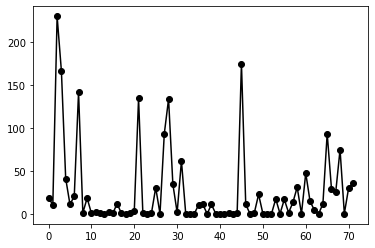

In [15]:
losses = [l.detach().numpy() for l in losses[-1]]
plt.plot(losses, 'ko-')

# TODO: CCA within FOVs to see shared components - are they tissue, gold, something else?